##  Acknowledgements

* Data set creation and learning code adapted from the PyTorch tutorial [Torchvision Object Detection Finetuning Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)
* Code for plotting detection bounding boxes taken from the tutorial [Faster R-CNN Object Detection with PyTorch](https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/)

In [1]:
from typing import Sequence, Dict

import os
import random
import yaml

from PIL import Image
import numpy as np
import sys
try:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
except:
    pass
import cv2
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [2]:
data_path = '/home/lucy/torch_detector/demo/synthetic_images'
class_metadata_file_path = '/home/lucy/torch_detector/demo/synthetic_images/demo_ycb_classes.yaml'
loss_file_name = '/home/lucy/torch_detector/demo/synthetic_images/fasterrcnn_ycb_loss.log'

num_classes = 5
num_epochs = 50
training_batch_size = 2
test_batch_size = 1
learning_rate = 0.001

In [3]:
class YCBDataset(object):
    def __init__(self, root, transforms, split_name):
        self.root = root
        self.transforms = transforms
        self.split_name = split_name

        self.data_list = []
        if os.path.isdir(self.root):
            self.data_list = self.__get_image_data(os.path.join(root, 'images', self.split_name),
                                                   os.path.join(root, self.split_name + '.yml'))

    def __get_image_data(self, image_dir: str,
                         annotations_file_path: str) -> Sequence[Dict[str, str]]:
        '''Returns a list of dictionaries containing image paths and image
        annotations for all images in the given directory. Each dictionary
        in the resulting list is of the following format:
        {
            'img': path to an image (starting from image_dir),
            'annotations': a dictionary containing class labels and bounding
                           box annotations for all objects in the image
        }

        Keyword arguments:
        image_dir: str -- name of a directory with RGB images
        annotations_file_path: str -- path to an image annotation file

        '''
        image_list = []
        annotations = {}
        with open(annotations_file_path, 'r') as annotations_file:
            annotations = yaml.load(annotations_file)

        for x in os.listdir(image_dir):
            name, _ = x.split('.')
            image_data = {}
            img_name = name + '.jpg'

            image_data['img'] = os.path.join(image_dir, img_name)
            image_data['annotations'] = annotations[img_name]
            image_list.append(image_data)
        return image_list

    def __getitem__(self, idx: int):
        img_path = self.data_list[idx]['img']
        annotations = self.data_list[idx]['annotations']

        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []
        for annotation in annotations:
            xmin = annotation['xmin']
            xmax = annotation['xmax']
            ymin = annotation['ymin']
            ymax = annotation['ymax']
            boxes.append([xmin, ymin, xmax, ymax])

            label = annotation['class_id']
            labels.append(label)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self) -> int:
        return len(self.data_list)

In [13]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

def get_model_instance_detection(num_classes):
    # load an instance detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

def get_prediction(img_path, class_metadata, threshold):
    img = Image.open(img_path)
    transform = T.ToTensor()
    img, _ = transform(img, None)
    with torch.no_grad():
        pred = model([img.to(device)])
    pred_class = [class_metadata[i][0] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].cpu().detach().numpy())]
    pred_score = list(pred[0]['scores'].cpu().detach().numpy())
    pred_t = [i for i, x in enumerate(pred_score) if x > threshold][-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class

def object_detection_api(img_path, class_metadata, threshold=0.5, rect_th=10,
                         text_size=0.5, text_th=1):
    boxes, pred_cls = get_prediction(img_path, class_metadata, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],
                      color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX,
                    text_size, (255,0,0), thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

with open(class_metadata_file_path) as file:
    class_metadata = yaml.load(file, Loader=yaml.FullLoader)
class_metadata[0] = ['__background', []]

dataset = YCBDataset(data_path, get_transform(train=True), 'train')
dataset_test = YCBDataset(data_path, get_transform(train=False), 'train')

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[0:100])
dataset_test = torch.utils.data.Subset(dataset_test, indices[100:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=training_batch_size,
                                          shuffle=True, num_workers=4,
                                          collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test,
                                               batch_size=test_batch_size,
                                               shuffle=False, num_workers=4,
                                               collate_fn=utils.collate_fn)

# get the model, define an optimiser, and train
model = get_model_instance_detection(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch,
                    print_freq=10, loss_file_name=loss_file_name)
    lr_scheduler.step()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:31: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Epoch: [0]  [ 0/50]  eta: 0:01:29  loss_classifier: 1.3358 (1.3358)  lr: 0.000021  loss_objectness: 0.0139 (0.0139)  loss_box_reg: 0.4499 (0.4499)  loss: 1.8108 (1.8108)  loss_rpn_box_reg: 0.0112 (0.0112)  time: 1.8000  data: 0.8687  max mem: 2394
Epoch: [0]  [10/50]  eta: 0:00:25  loss_classifier: 0.5038 (0.6576)  lr: 0.000225  loss_objectness: 0.0064 (0.0194)  loss_box_reg: 0.4499 (0.4226)  loss: 1.0000 (1.1122)  loss_rpn_box_reg: 0.0131 (0.0125)  time: 0.6342  data: 0.0873  max mem: 3574
Epoch: [0]  [20/50]  eta: 0:00:17  loss_classifier: 0.4199 (0.5273)  lr: 0.000429  loss_objectness: 0.0064 (0.0160)  loss_box_reg: 0.3291 (0.3533)  loss: 0.8218 (0.9133)  loss_rpn_box_reg: 0.0154 (0.0167)  time: 0.5337  data: 0.0099  max mem: 3578
Epoch: [0]  [30/50]  eta: 0:00:11  loss_classifier: 0.3734 (0.4784)  lr: 0.000633  loss_objectness: 0.0055 (0.0174)  loss_box_reg: 0.2476 (0.3203)  loss: 0.6565 (0.8352)  loss_rpn_box_reg: 0.0205 (0.0192)  time: 0.5550  data: 0.0106  max mem: 3578
Epoch: [

Epoch: [5]  [30/50]  eta: 0:00:10  loss_classifier: 0.1040 (0.1241)  lr: 0.000100  loss_objectness: 0.0009 (0.0031)  loss_box_reg: 0.0477 (0.0585)  loss: 0.1627 (0.1998)  loss_rpn_box_reg: 0.0135 (0.0141)  time: 0.5147  data: 0.0105  max mem: 3906
Epoch: [5]  [40/50]  eta: 0:00:05  loss_classifier: 0.1337 (0.1295)  lr: 0.000100  loss_objectness: 0.0007 (0.0028)  loss_box_reg: 0.0458 (0.0596)  loss: 0.1934 (0.2060)  loss_rpn_box_reg: 0.0142 (0.0141)  time: 0.5233  data: 0.0108  max mem: 3906
Epoch: [5]  [49/50]  eta: 0:00:00  loss_classifier: 0.1352 (0.1323)  lr: 0.000100  loss_objectness: 0.0007 (0.0027)  loss_box_reg: 0.0603 (0.0601)  loss: 0.2009 (0.2092)  loss_rpn_box_reg: 0.0127 (0.0141)  time: 0.5421  data: 0.0111  max mem: 3906
Epoch: [5] Total time: 0:00:27 (0.5463 s / it)
Epoch: [6]  [ 0/50]  eta: 0:01:07  loss_classifier: 0.1493 (0.1493)  lr: 0.000010  loss_objectness: 0.0036 (0.0036)  loss_box_reg: 0.0788 (0.0788)  loss: 0.2457 (0.2457)  loss_rpn_box_reg: 0.0140 (0.0140)  tim

Epoch: [11]  [ 0/50]  eta: 0:01:08  loss_classifier: 0.1161 (0.1161)  lr: 0.000001  loss_objectness: 0.0009 (0.0009)  loss_box_reg: 0.0430 (0.0430)  loss: 0.1709 (0.1709)  loss_rpn_box_reg: 0.0110 (0.0110)  time: 1.3614  data: 0.8646  max mem: 3906
Epoch: [11]  [10/50]  eta: 0:00:24  loss_classifier: 0.1142 (0.1142)  lr: 0.000001  loss_objectness: 0.0009 (0.0030)  loss_box_reg: 0.0430 (0.0522)  loss: 0.1709 (0.1812)  loss_rpn_box_reg: 0.0110 (0.0118)  time: 0.6114  data: 0.0878  max mem: 3906
Epoch: [11]  [20/50]  eta: 0:00:17  loss_classifier: 0.1086 (0.1119)  lr: 0.000001  loss_objectness: 0.0013 (0.0023)  loss_box_reg: 0.0396 (0.0503)  loss: 0.1680 (0.1764)  loss_rpn_box_reg: 0.0116 (0.0119)  time: 0.5375  data: 0.0106  max mem: 3906
Epoch: [11]  [30/50]  eta: 0:00:11  loss_classifier: 0.0969 (0.1048)  lr: 0.000001  loss_objectness: 0.0013 (0.0023)  loss_box_reg: 0.0345 (0.0477)  loss: 0.1672 (0.1668)  loss_rpn_box_reg: 0.0115 (0.0120)  time: 0.5348  data: 0.0108  max mem: 3906
Epoc

Epoch: [16]  [20/50]  eta: 0:00:16  loss_classifier: 0.1009 (0.1086)  lr: 0.000000  loss_objectness: 0.0009 (0.0022)  loss_box_reg: 0.0413 (0.0433)  loss: 0.1588 (0.1654)  loss_rpn_box_reg: 0.0112 (0.0113)  time: 0.5222  data: 0.0105  max mem: 3906
Epoch: [16]  [30/50]  eta: 0:00:10  loss_classifier: 0.0956 (0.1040)  lr: 0.000000  loss_objectness: 0.0009 (0.0018)  loss_box_reg: 0.0413 (0.0426)  loss: 0.1489 (0.1602)  loss_rpn_box_reg: 0.0109 (0.0118)  time: 0.5257  data: 0.0107  max mem: 3906
Epoch: [16]  [40/50]  eta: 0:00:05  loss_classifier: 0.0851 (0.1011)  lr: 0.000000  loss_objectness: 0.0008 (0.0017)  loss_box_reg: 0.0442 (0.0449)  loss: 0.1382 (0.1592)  loss_rpn_box_reg: 0.0099 (0.0114)  time: 0.5155  data: 0.0109  max mem: 3906
Epoch: [16]  [49/50]  eta: 0:00:00  loss_classifier: 0.0945 (0.1018)  lr: 0.000000  loss_objectness: 0.0009 (0.0018)  loss_box_reg: 0.0450 (0.0459)  loss: 0.1504 (0.1610)  loss_rpn_box_reg: 0.0110 (0.0116)  time: 0.5102  data: 0.0107  max mem: 3906
Epoc

Epoch: [21]  [40/50]  eta: 0:00:05  loss_classifier: 0.0864 (0.1015)  lr: 0.000000  loss_objectness: 0.0007 (0.0012)  loss_box_reg: 0.0448 (0.0441)  loss: 0.1493 (0.1581)  loss_rpn_box_reg: 0.0111 (0.0113)  time: 0.5201  data: 0.0106  max mem: 3906
Epoch: [21]  [49/50]  eta: 0:00:00  loss_classifier: 0.0818 (0.1013)  lr: 0.000000  loss_objectness: 0.0006 (0.0012)  loss_box_reg: 0.0433 (0.0457)  loss: 0.1415 (0.1597)  loss_rpn_box_reg: 0.0115 (0.0115)  time: 0.5246  data: 0.0105  max mem: 3906
Epoch: [21] Total time: 0:00:26 (0.5364 s / it)
Epoch: [22]  [ 0/50]  eta: 0:00:46  loss_classifier: 0.0857 (0.0857)  lr: 0.000000  loss_objectness: 0.0053 (0.0053)  loss_box_reg: 0.0576 (0.0576)  loss: 0.1584 (0.1584)  loss_rpn_box_reg: 0.0098 (0.0098)  time: 0.9282  data: 0.4460  max mem: 3906
Epoch: [22]  [10/50]  eta: 0:00:22  loss_classifier: 0.1086 (0.1065)  lr: 0.000000  loss_objectness: 0.0012 (0.0018)  loss_box_reg: 0.0426 (0.0515)  loss: 0.1677 (0.1703)  loss_rpn_box_reg: 0.0098 (0.0105)

Epoch: [27]  [ 0/50]  eta: 0:01:12  loss_classifier: 0.0773 (0.0773)  lr: 0.000000  loss_objectness: 0.0001 (0.0001)  loss_box_reg: 0.0305 (0.0305)  loss: 0.1258 (0.1258)  loss_rpn_box_reg: 0.0180 (0.0180)  time: 1.4465  data: 0.7687  max mem: 3906
Epoch: [27]  [10/50]  eta: 0:00:23  loss_classifier: 0.1020 (0.1015)  lr: 0.000000  loss_objectness: 0.0005 (0.0021)  loss_box_reg: 0.0383 (0.0431)  loss: 0.1561 (0.1603)  loss_rpn_box_reg: 0.0129 (0.0136)  time: 0.5840  data: 0.0790  max mem: 3906
Epoch: [27]  [20/50]  eta: 0:00:16  loss_classifier: 0.0967 (0.1051)  lr: 0.000000  loss_objectness: 0.0006 (0.0017)  loss_box_reg: 0.0435 (0.0495)  loss: 0.1509 (0.1690)  loss_rpn_box_reg: 0.0117 (0.0128)  time: 0.5080  data: 0.0110  max mem: 3906
Epoch: [27]  [30/50]  eta: 0:00:10  loss_classifier: 0.0906 (0.1037)  lr: 0.000000  loss_objectness: 0.0016 (0.0016)  loss_box_reg: 0.0428 (0.0480)  loss: 0.1502 (0.1655)  loss_rpn_box_reg: 0.0112 (0.0122)  time: 0.5282  data: 0.0113  max mem: 3906
Epoc

Epoch: [32]  [20/50]  eta: 0:00:17  loss_classifier: 0.0990 (0.1089)  lr: 0.000000  loss_objectness: 0.0012 (0.0032)  loss_box_reg: 0.0439 (0.0543)  loss: 0.1667 (0.1780)  loss_rpn_box_reg: 0.0112 (0.0116)  time: 0.5190  data: 0.0102  max mem: 3906
Epoch: [32]  [30/50]  eta: 0:00:11  loss_classifier: 0.0961 (0.1046)  lr: 0.000000  loss_objectness: 0.0012 (0.0027)  loss_box_reg: 0.0427 (0.0486)  loss: 0.1546 (0.1675)  loss_rpn_box_reg: 0.0112 (0.0115)  time: 0.5178  data: 0.0107  max mem: 3906
Epoch: [32]  [40/50]  eta: 0:00:05  loss_classifier: 0.0961 (0.1041)  lr: 0.000000  loss_objectness: 0.0010 (0.0023)  loss_box_reg: 0.0472 (0.0468)  loss: 0.1546 (0.1647)  loss_rpn_box_reg: 0.0112 (0.0115)  time: 0.5218  data: 0.0106  max mem: 3906
Epoch: [32]  [49/50]  eta: 0:00:00  loss_classifier: 0.1026 (0.1058)  lr: 0.000000  loss_objectness: 0.0009 (0.0022)  loss_box_reg: 0.0418 (0.0468)  loss: 0.1744 (0.1662)  loss_rpn_box_reg: 0.0114 (0.0114)  time: 0.5076  data: 0.0105  max mem: 3906
Epoc

Epoch: [37]  [40/50]  eta: 0:00:05  loss_classifier: 0.0956 (0.1024)  lr: 0.000000  loss_objectness: 0.0016 (0.0029)  loss_box_reg: 0.0455 (0.0490)  loss: 0.1634 (0.1659)  loss_rpn_box_reg: 0.0116 (0.0116)  time: 0.5379  data: 0.0105  max mem: 3906
Epoch: [37]  [49/50]  eta: 0:00:00  loss_classifier: 0.1023 (0.1022)  lr: 0.000000  loss_objectness: 0.0016 (0.0028)  loss_box_reg: 0.0287 (0.0454)  loss: 0.1415 (0.1617)  loss_rpn_box_reg: 0.0106 (0.0113)  time: 0.5209  data: 0.0103  max mem: 3906
Epoch: [37] Total time: 0:00:26 (0.5387 s / it)
Epoch: [38]  [ 0/50]  eta: 0:01:06  loss_classifier: 0.0951 (0.0951)  lr: 0.000000  loss_objectness: 0.0010 (0.0010)  loss_box_reg: 0.0465 (0.0465)  loss: 0.1592 (0.1592)  loss_rpn_box_reg: 0.0167 (0.0167)  time: 1.3241  data: 0.7951  max mem: 3906
Epoch: [38]  [10/50]  eta: 0:00:23  loss_classifier: 0.0797 (0.0874)  lr: 0.000000  loss_objectness: 0.0008 (0.0015)  loss_box_reg: 0.0333 (0.0347)  loss: 0.1356 (0.1363)  loss_rpn_box_reg: 0.0109 (0.0127)

Epoch: [43]  [ 0/50]  eta: 0:01:17  loss_classifier: 0.0779 (0.0779)  lr: 0.000000  loss_objectness: 0.0118 (0.0118)  loss_box_reg: 0.0245 (0.0245)  loss: 0.1273 (0.1273)  loss_rpn_box_reg: 0.0131 (0.0131)  time: 1.5561  data: 1.0286  max mem: 3906
Epoch: [43]  [10/50]  eta: 0:00:25  loss_classifier: 0.0986 (0.1104)  lr: 0.000000  loss_objectness: 0.0003 (0.0018)  loss_box_reg: 0.0368 (0.0434)  loss: 0.1646 (0.1677)  loss_rpn_box_reg: 0.0100 (0.0122)  time: 0.6393  data: 0.1031  max mem: 3906
Epoch: [43]  [20/50]  eta: 0:00:17  loss_classifier: 0.0850 (0.0949)  lr: 0.000000  loss_objectness: 0.0005 (0.0028)  loss_box_reg: 0.0353 (0.0415)  loss: 0.1319 (0.1508)  loss_rpn_box_reg: 0.0097 (0.0116)  time: 0.5399  data: 0.0106  max mem: 3906
Epoch: [43]  [30/50]  eta: 0:00:11  loss_classifier: 0.0755 (0.0944)  lr: 0.000000  loss_objectness: 0.0010 (0.0023)  loss_box_reg: 0.0310 (0.0424)  loss: 0.1249 (0.1507)  loss_rpn_box_reg: 0.0097 (0.0115)  time: 0.5229  data: 0.0107  max mem: 3906
Epoc

Epoch: [48]  [20/50]  eta: 0:00:16  loss_classifier: 0.1075 (0.1117)  lr: 0.000000  loss_objectness: 0.0014 (0.0024)  loss_box_reg: 0.0387 (0.0460)  loss: 0.1592 (0.1719)  loss_rpn_box_reg: 0.0100 (0.0118)  time: 0.5061  data: 0.0107  max mem: 3906
Epoch: [48]  [30/50]  eta: 0:00:10  loss_classifier: 0.0878 (0.1010)  lr: 0.000000  loss_objectness: 0.0007 (0.0025)  loss_box_reg: 0.0378 (0.0442)  loss: 0.1441 (0.1591)  loss_rpn_box_reg: 0.0114 (0.0114)  time: 0.5108  data: 0.0115  max mem: 3906
Epoch: [48]  [40/50]  eta: 0:00:05  loss_classifier: 0.0775 (0.0984)  lr: 0.000000  loss_objectness: 0.0002 (0.0022)  loss_box_reg: 0.0341 (0.0418)  loss: 0.1299 (0.1543)  loss_rpn_box_reg: 0.0107 (0.0119)  time: 0.5240  data: 0.0111  max mem: 3906
Epoch: [48]  [49/50]  eta: 0:00:00  loss_classifier: 0.0952 (0.0993)  lr: 0.000000  loss_objectness: 0.0005 (0.0019)  loss_box_reg: 0.0376 (0.0450)  loss: 0.1381 (0.1577)  loss_rpn_box_reg: 0.0098 (0.0115)  time: 0.5349  data: 0.0105  max mem: 3906
Epoc

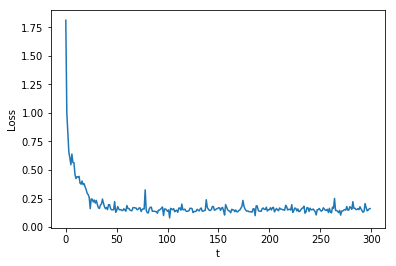

In [6]:
losses = np.genfromtxt(loss_file_name)
plt.plot(losses)
plt.xlabel('t')
plt.ylabel('Loss')
plt.show()

In [11]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

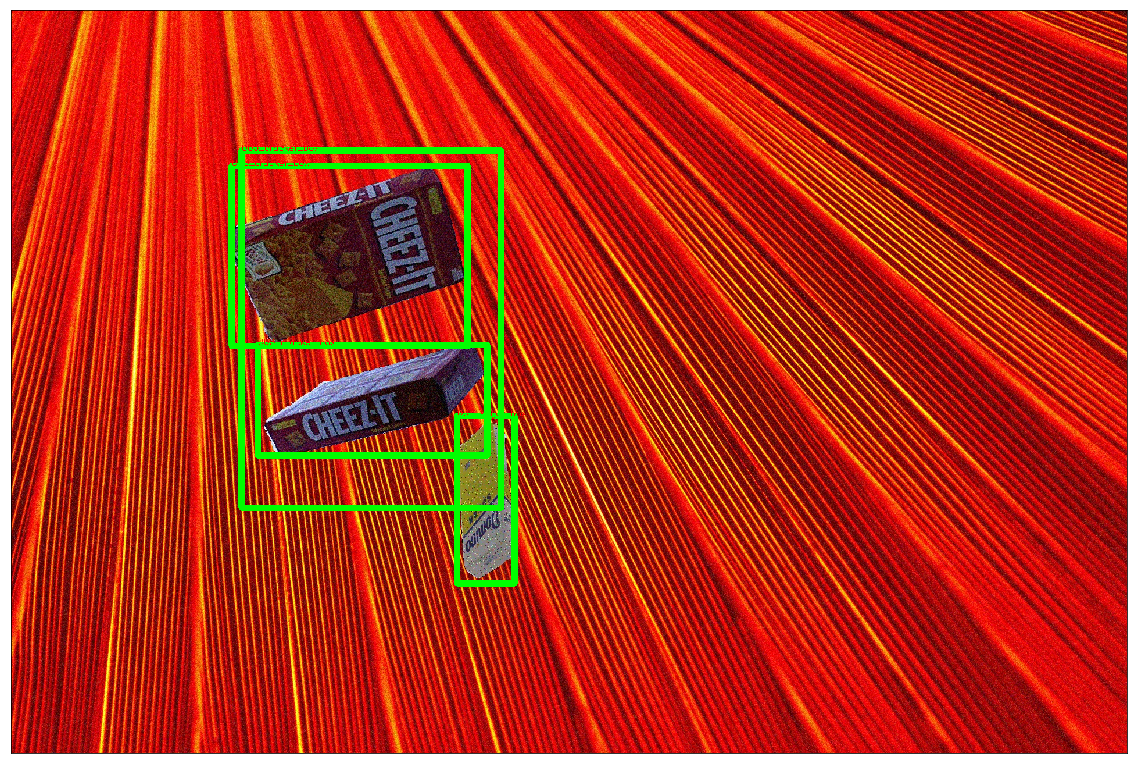

In [14]:
object_detection_api('/home/lucy/torch_detector/demo/synthetic_images/images/train/train_124.jpg',
                     class_metadata, threshold=0.5)

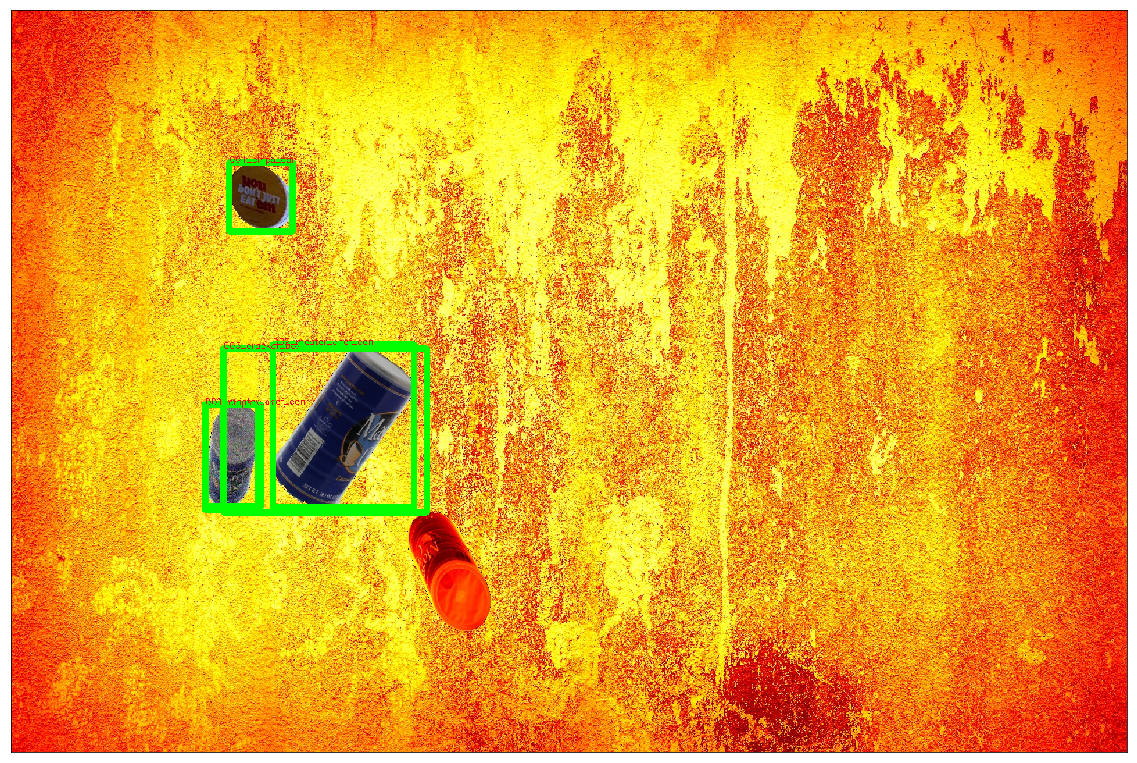

In [15]:
object_detection_api('/home/lucy/torch_detector/demo/synthetic_images/images/train/train_150.jpg',
                     class_metadata, threshold=0.5)

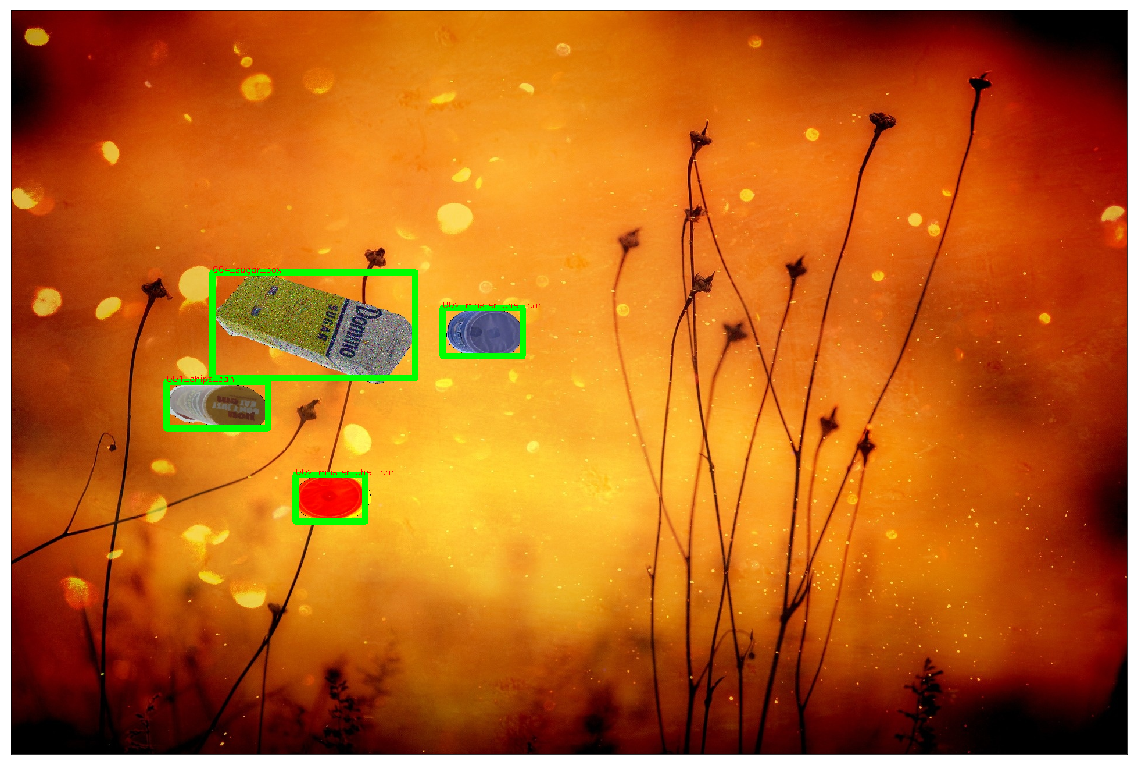

In [16]:
object_detection_api('/home/lucy/torch_detector/demo/synthetic_images/images/train/train_101.jpg',
                     class_metadata, threshold=0.5)